### 1. Extract color palette from an image
- image should be named `image.jpg`

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

%matplotlib inline
%ls

sample_data/


In [2]:
image = cv2.imread('image.png')
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

The type of this input is <class 'NoneType'>


AttributeError: ignored

In [3]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    # rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return hex_colors

In [4]:
colors = get_colors(get_image('image.png'), 5, True)

error: ignored

### 2. Map color to elements
- color closest to white/black : text
- color that is far from text color and has high saturation : background, buttons
- color most similar to the background color: box color

In [5]:
# hex to rgb
from PIL import ImageColor
rgbs = [ImageColor.getcolor(x, "RGB") for x in colors]

NameError: ignored

In [6]:
import colorsys
hlss = []
for rgb in rgbs:
  rgb = np.array(rgb) / 255
  h, l, s = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
  hlss.append(tuple([h, l, s]))
hlss = np.array(hlss)
hlss

NameError: ignored

In [11]:
# max_index = hlss.argmax(axis=0)
# min_index = hlss.argmin(axis=0)

def closest_color(rgb, colors):
    r, g, b = rgb
    color_diffs = []
    for i, color in enumerate(colors):
        cr, cg, cb = color
        color_diff = np.sqrt(abs(r - cr)**2 + abs(g - cg)**2 + abs(b - cb)**2)
        if color_diff != 0:
          color_diffs.append((color_diff, i))
    return min(color_diffs)[1]

In [ ]:
# color closest to white/black
text_color = max_index[1]
text_standard = 1 # white
if 1 - hlss[max_index[1]][1] > hlss[min_index[1]][1]:
  text_color = min_index[1]
  text_standard = 0 # black
text_color

In [ ]:
# color that is far from text color and has high saturation
sum = hlss.sum(axis=1)
bg_color = sum.argmax() # bright
if hlss[bg_color][1] == 1: # if it is white
  sum[bg_color] = 0
  bg_color = sum.argmax() # choose next brightest color

if text_standard == 1:
  bg_color = sum.argmin() # dark
  if hlss[bg_color][1] == 0: # if it is black
    sum[bg_color] = 1
    bg_color = sum.argmin() # choose next darkest color

bg_color

In [ ]:
# color most similar to the background color
box_color = closest_color(rgbs[bg_color], rgbs)
box_color

In [ ]:
css = "body { background-color: [bg_color]; color: [text_color]; } .btn { background-color: [bg_color];} .col-lg-12, .col-lg-6, .col-lg-3 { background_color: [box_color]}"
css = css.replace("[bg_color]", colors[bg_color])
css = css.replace("[text_color]", colors[text_color])
css = css.replace("[box_color]", colors[box_color])
css

### Function

In [8]:
def img_to_css(image_path):
  colors = get_colors(get_image(image_path), 6, True)

  # get rgb
  rgbs = [ImageColor.getcolor(x, "RGB") for x in colors]

  # get hls
  hlss = []
  for rgb in rgbs:
    rgb = np.array(rgb) / 255
    h, l, s = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
    hlss.append(tuple([h, l, s]))
  hlss = np.array(hlss)
  
  # text color
  max_index = hlss.argmax(axis=0)
  min_index = hlss.argmin(axis=0)

  # color closest to white/black
  text_color = max_index[1]
  text_standard = 1 # white
  if 1 - hlss[max_index[1]][1] > hlss[min_index[1]][1]:
    text_color = min_index[1]
    text_standard = 0 # black
  
  # color that is far from text color and has high saturation
  sum = hlss.sum(axis=1)
  bg_color = sum.argmax() # bright
  if hlss[bg_color][1] == 1: # if it is white
    sum[bg_color] = 0
    bg_color = sum.argmax() # choose next brightest color

  if text_standard == 1:
    bg_color = sum.argmin() # dark
    if hlss[bg_color][1] == 0: # if it is black
      sum[bg_color] = 1
      bg_color = sum.argmin() # choose next darkest color

  # color most similar to the background color
  box_color = closest_color(rgbs[bg_color], rgbs)

  # inject colors to css
  css = "body { background-color: [bg_color]; color: [text_color]; } .btn, .nav-link { background-color: [bg_color]; color: [text_color] !important; border: none} .row .col-lg-12 > div, .row .col-lg-6 > div, .row .col-lg-3 > div { background-color: [box_color]}"
  css = css.replace("[bg_color]", colors[bg_color])
  css = css.replace("[text_color]", colors[text_color])
  css = css.replace("[box_color]", colors[box_color])

  return css


In [9]:
import requests
import urllib.request
import json

access_key = "Dt5ThDLH--KKIB9ujPOL2iVf8RRnbymQ2rzLEgynIvA"
unsplash = "https://api.unsplash.com/search/photos/?query=illustration&orientation=squarish&client_id={}".format(access_key)

contents = urllib.request.urlopen(unsplash).read()
contents = json.loads(contents)
for i, pic in enumerate(contents["results"]):
  pic_url = pic["urls"]["regular"]
  pic_path = "image{}.jpg".format(i)
  with open(pic_path, 'wb') as handle:
      response = requests.get(pic_url, stream=True)

      if not response.ok:
          print(response)

      for block in response.iter_content(1024):
          if not block:
              break

          handle.write(block)

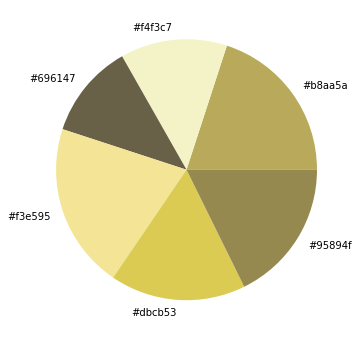

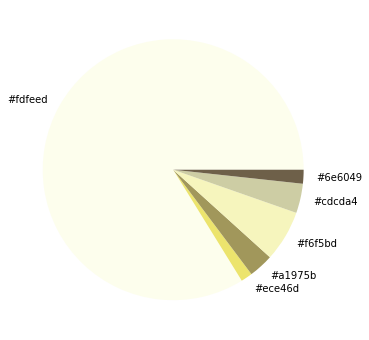

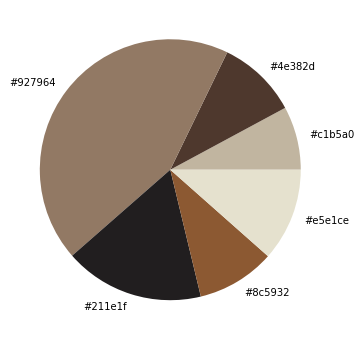

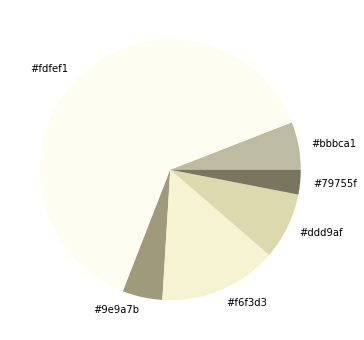

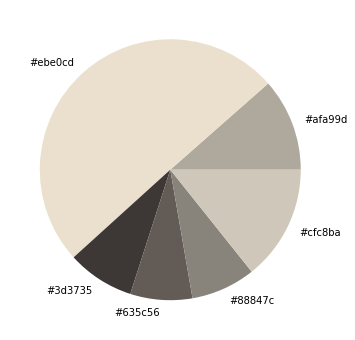

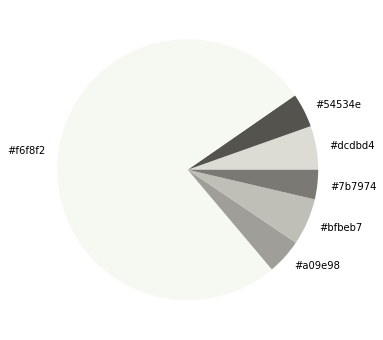

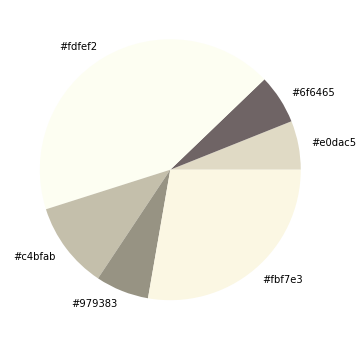

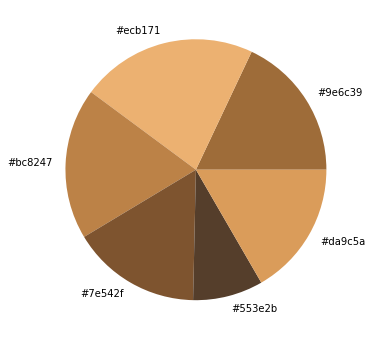

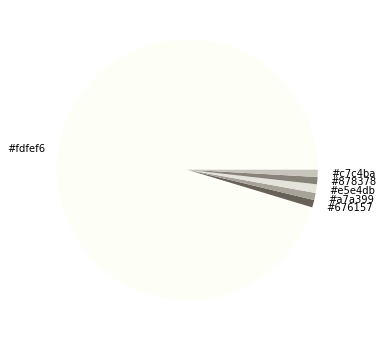

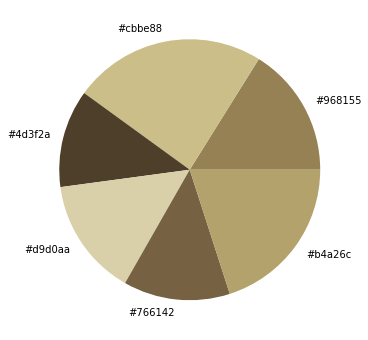

In [12]:
for i in range(10):
  image_path = "image{}.jpg".format(i)
  css_path = "styles{}.css".format(i)
  css = img_to_css(image_path)
  with open(css_path, "w") as css_file:
    css_file.write(css)

In [ ]:
%ls